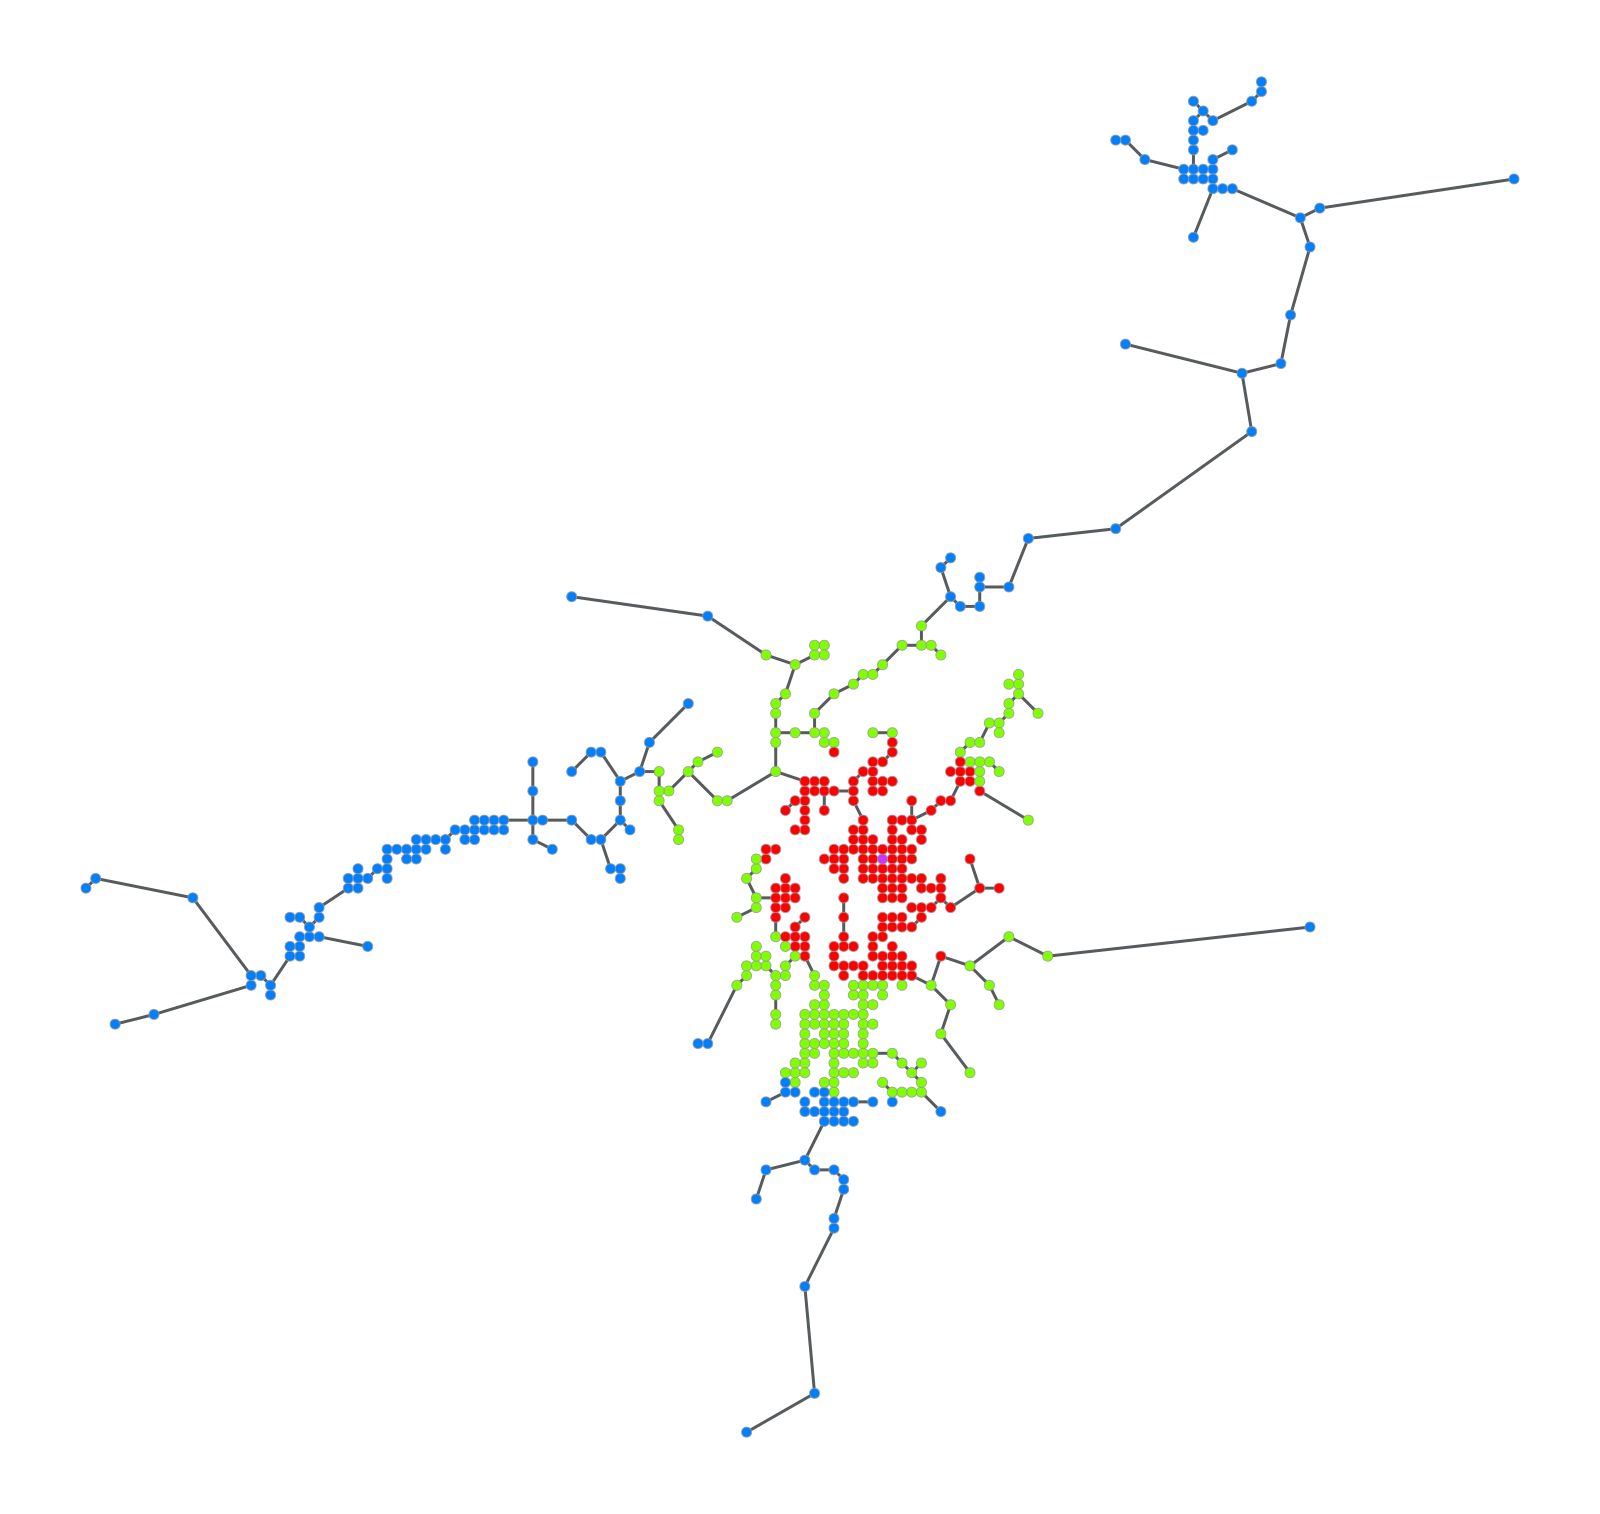

In [3]:
import numpy as np
import graph_tool.all as gt
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取图数据
read_graph, read_pos = fo.read_files("./networks_date/2keihan2_pop_500_mst.net", False)

# 创建并赋值位置属性，确保数据为 float
pos = read_graph.new_vertex_property("vector<double>")
positions = []

for v in read_graph.vertices():
    coords = read_pos[v]
    coords_float = [float(coords[0]), float(coords[1])]  # 强制转换为 float
    pos[v] = coords_float
    positions.append(coords_float)

positions = np.array(positions, dtype=np.float64)  # 确保是 numpy float 数组

# **计算介数中心性，并选择最大介数中心性点作为新质心**
betweenness_centrality, _ = gt.betweenness(read_graph)  # 计算介数中心性
center_v = max(read_graph.vertices(), key=lambda v: betweenness_centrality[v])  # 选取介数中心性最大的节点

# 获取该节点的坐标作为新的中心点
center_x, center_y = pos[center_v]

# 计算节点到新中心的距离并排序
distances = np.linalg.norm(positions - np.array([center_x, center_y]), axis=1)
sorted_indices = np.argsort(distances)
num_nodes = len(positions)

# **根据距离将节点分为三环**
node_layers = np.zeros(num_nodes, dtype=int)
for idx, node_idx in enumerate(sorted_indices):
    if idx < num_nodes / 3:
        node_layers[node_idx] = 1
    elif idx < 2 * num_nodes / 3:
        node_layers[node_idx] = 2
    else:
        node_layers[node_idx] = 3

# 创建节点颜色属性
layer_prop = read_graph.new_vertex_property("int")
for idx, layer in enumerate(node_layers):
    layer_prop[read_graph.vertex(idx)] = layer

# **映射颜色**
color_map = {1: (1, 0, 0, 1), 2: (0.5, 1, 0, 1), 3: (0, 0.5, 1, 1)}  # 颜色需为 RGBA 格式
vertex_colors = read_graph.new_vertex_property("vector<double>")

for v in read_graph.vertices():
    vertex_colors[v] = color_map[layer_prop[v]]

# **标记介数中心点**
center_vertex_color = read_graph.new_vertex_property("vector<double>")
for v in read_graph.vertices():
    center_vertex_color[v] = vertex_colors[v]  # 默认使用原颜色

# **将介数中心点标记为紫色**
center_vertex_color[center_v] = (0.8, 0.2, 1, 1)  # 紫色

# **绘图**
gt.graph_draw(read_graph,
              pos=pos,
              vertex_fill_color=center_vertex_color,  # 确保颜色映射正确
              vertex_size=5,
              edge_pen_width=1.5,
              output_size=(800, 800))

plt.show()
